## Binarisation

***Vocabulaire:*** Dans ce TP: J'emploierai le mot "variable catégorielle", synomime de "variable qualitative". Les "catégories" seront toujours des entiers. Le mot "catégorie" se transformera en "classe" pour les variables cibles (output).  


On va utiliser un peu de tensorflow car les loss de classifications sont mieux nomées.


### One hot vector



Considérons $k$ catégories. Le hot-vecteur associé à $i$-ième catégorie c'est le vecteur nul de taille $k$ auquel la $i$-ème composante est mise à $1$.

Exemple, s'il y a $3$ catégories possibles:

    0 ---> [1.,0.,0.]
    1 ---> [0.,1.,0.]
    2 ---> [0.,0.,1.]

Cela peut être vu comme le vecteur de probabilité mettant tout son poids sur la $i$-ème catégorie. Notez que ces vecteurs sont composés de flottants (puisque c'est des probas).


La binarisation d'une variable catégorielle, c'est sa transformation en hot-vecteur.

Ci-dessous on binarise un échantillon d'une variable catégorielle $N$ pouvant prendre 5 valeurs.

In [ ]:
import tensorflow as tf
N=[3,1,2,4,0,1,1,0,4]
N_proba=tf.one_hot(N,5)
N_proba

### Pour une variable descriptive


Quand on a une variable descriptive catégorielle, il est indispensable de la binariser. Comprenons cela avec un exemple:

On dispose de 2 variables descriptives:

* $X$ la quantité d'alcool consommée par un conducteur.
*  $N$ le numéro du département du véhicule.

On veut créer un réseau de neurone pour prédire le nombre d'accident. Sans binarisation, un neurone de la seconde couche reçoit une activation de la forme:

$$
  relu( \ X w_{0}+ N w_{1}\ + b )
$$

Problème: Pour les véhicules du Var ($N=83$), le facteur $N w_{1}$ est beaucoup plus grand (en valeur absolu) que pour les véhicules de l'Ain ($N=1$). C'est absurde! Cela rendra le modèle  impossible à entrainer.


Si nous binarisons $N$, cela oblige à introduire autant de paramètres $w$ que de département. Un neurone de la seconde couche reçoit alors:  
$$
relu( \ X w_0 +  1_{N=1}\, w_1 +  1_{N=2}\, w_2 + ... + b ) \\ = relu( \ X w_0 + w_N + b  \ )
$$


La variable $N$ permet ainsi de sélectionner un biais $w_N$ propre au département. Ce qui est naturel: on peut imaginer qu'il y a des département où l'on tient mieux l'alcool que d'autre.



Notons que grâce à la binarisation, c'est "l'appartenance à un département" qui est prise en compte, mais pas "le numéro du département".



### Autre technique

Quand le nombre de catégories devient très grand, la binarisation devient couteuse. C'est le cas notamment quand les variables sont des mots (autant de catégorie que de mot dans le dictionnaire).

Il existe alors une seconde technique: l'embeding dont nous parlerons quand on traitera les modèles de languages.

## Classification multi-classe

### Rappel

Les modèles de classification pour $k$ classes sont construits ainsi:

1. On choisit une fonction $f_\theta$ à valeur dans $\mathbb R^k$ où $k$ est le nombre de classe. Le résultat de cette fonction est appelée "logits":
$$
\hat Y_{logits} := f_\theta(X)
$$
2. On applique ensuite la fonction softmax pour obtenir un vecteur de proba
$$
\hat Y_{proba} := \text{SM}(f_\theta(X)) = model_\theta(X)
$$

### Sparse cross entropy

Considérons  une variable cible  catégorielle $Y\in 0,...,k-1$.

Notons $Y_{proba}$ sa version binarisée. Cette hot-proba se compare naturellement avec le résultat d'un modèle $\hat Y_{proba}$ à l'aide de la Cross-Entropie qui est une distance entre proba:
$$
\mathtt{CE}(Y_{proba},\hat Y_{proba}) = -\sum_{i=0}^{k-1} Y_{proba}[i] \log(\hat Y_{proba}[i])
$$

Mais en pratique, le côté hot-vecteur de $Y_{proba}$ rend la sommation inutile. On va préférer utiliser la Sparse-Cross-Entropy:

$$
\mathtt{SCE}(Y,\hat Y_{proba}) = -\log(\hat Y_{proba}[Y])
$$




### S'arrêter aux logits


Quand le modèle est entrainé, pour prédire une classe, on va prendre celle dont la proba estimée est la plus grande:
$$
\hat Y = \text{argmax}_i \hat Y_{proba}[i]  = \text{argmax}_i [\text{SM}(f_\theta(X))]_i
$$

La fonction softmax étant basée sur l'exponentiel, qui est croissante, on a aussi:
$$
\hat Y  = \text{argmax}_i f_\theta(X)_i
$$

Par conséquent, quant on construit un modèle, on peut volontairement oublié la fonction softmax de la dernière couche.  Cela fait gagner du temps pendant l'évaluation du modèle (ce qui est essentiel pour qu'il puisse tourner sur notre smartphone).


Mais du coup, il faut impérativement ajouter la fonction softmax dans la loss, car une cross-entropie doit comparer des probabilitées. Cela donne la Cross-Entropy-from-Logits et sa version plus pratique: la Sparse-Cross-Entropy-from-Logits

$$
\mathtt{SCEL}(Y,\hat Y_{logits})= -\log(\text{SM}(\hat Y_{logits})[Y])
$$
$$
= -\log \Big( {\exp(\hat Y_{logits}[Y])\over \sum_i \exp(\hat Y_{logits}[i] } \Big)
$$



***A vous:*** Vérifiez que si  $\hat Y_{proba}$ est un vecteur de proba, alors:
$$
\mathtt{SCE}(Y,\hat Y_{proba}) = \mathtt{SCEL}(Y,\log(\hat Y_{proba}))
$$

### Code Tensorflow

In [ ]:
import tensorflow as tf
Y=tf.constant([1]) #une catégorie
Y_proba=tf.constant([[0.,1,0]]) #le hot-vecteur associé
Y_proba_pred=tf.constant([[0.1,0.8,0.1]]) #une prédiction (au pif)

Calculons l'écart en la prédiction et la vraie classe, via la `SCE` de tensorflow:

In [ ]:
loss=tf.keras.losses.sparse_categorical_crossentropy(Y,Y_proba_pred)
loss.numpy()

Vérifions:

In [ ]:
import numpy as np
-np.log(0.8)

Idem mais sans la version sparse:

In [ ]:
loss=tf.keras.losses.categorical_crossentropy(Y_proba,Y_proba_pred)
loss.numpy()

En faisant un détour par la version `from_logits`:

In [ ]:
loss=tf.keras.losses.sparse_categorical_crossentropy(Y,tf.math.log(Y_proba_pred),from_logits=True)
loss.numpy()

***A vous:*** Qu'est-ce qui peut provoquer le warning suivant?

    UserWarning: "`sparse_categorical_crossentropy` received `from_logits=True`, but the `output` argument was produced by a sigmoid or softmax activation and thus does not represent logits. Was this intended?

Essayez de le faire apparaitre.

### Code torch

In [ ]:
import torch
Y=torch.tensor([1],dtype=torch.int64)
Y_proba=torch.tensor([[0.,1,0]],dtype=torch.float32)
Y_proba_pred=torch.tensor([[0.1,0.8,0.1]],dtype=torch.float32)

C'est la même fonction qui code `SCEL` et `CEL`, elle s'adapte en fonction des arguments.

Mais à ma connaissance, il n'y a que la version "from-logits". On ajoute donc un `log` pour la version "from-proba"

In [ ]:
loss_fn=torch.nn.CrossEntropyLoss()
loss=loss_fn(torch.log(Y_proba_pred),Y)
loss

In [ ]:
loss_fn(torch.log(Y_proba_pred),Y_proba)


### La loss Hinge



Elle ne passe pas par la fonction softmax. Elle se calcule directement sur des logits. Elle est inspirée des modèles `SVM` (Support Vector Machine), qui tenaient le haut du pavé avant le succés des réseaux de neurone.

Considérons une constante $\Delta>0$. On définit:
$$
\mathtt{Hinge}(Y,\hat Y_{logits}) = \sum_{i\neq Y} \max(0, \hat Y_{logits}[i] - \hat Y_{logits}[Y]  + \Delta  )
$$
Pour avoir une loss de zéro, il faut que le logit de la bonne classe $\hat Y_{logits}[Y]$ dépasse d'au moins $\Delta$ le score des  logits des autres classes $\hat Y_{logits}[i]$.

La valeur de $\Delta$ n'a pas beaucoup d'importante pratique. On prend souvent $\Delta=1$.



Cette loss est  appelée 'hinge'. On utilise parfois  la hinge "au carré" pour pénaliser violemment les mauvais logits:
$$
\sum_{i\neq Y} \Big(\max(0, \hat Y_{logits}[i] - \hat Y_{logits}[Y]  + \Delta  )\Big)^2
$$





## Classification binaire

### Deux façons de faire.

Supposons que l'on a un problème de classification à 2 classes (ex: chat/chien). On parle alors que classification binaire. Il y a 2 technique pour traiter ce cas là:

1. La technique softmax (comme précédemment). On choisit une fonction $f_\theta$ à valeur dans $\mathbb R^2$ puis on pose:
$$
model_\theta(X)= SM(f_\theta(X))
$$
qui renvoie un vecteur $[1-p,p]$ donnant les proba des 2 classes.

2. La technique sigmoide: on choisit une fonction $g_\theta$ à valeur dans $\mathbb R$ puis on pose:
$$
model_\theta(X)= \sigma(g_\theta(X))
$$
où $\sigma$ est la fonction sigmoide
$$
\sigma(x) = {1 \over 1+e^{-x}}
$$
 qui est croissante et arrive dans $[0,1]$. Cela fournit donc une probabilité qui sera affectée à une des deux classes (la classe 1 par exemple).



### C'est idem


Nous montrons que les deux manières d'aborder la classification binaire sont équivalents.

La fonction $f_\theta$ arrive dans $\mathbb R^2$, on peut donc l'écrire
$$
f_{\theta}(x)=[f_{\theta,0}(x),f_{\theta,1}(x)] = [f_0,f_1]
$$


Posons $g:=f_1-f_0$. Le softmax de $[f_0,f_1]$ est:
$$
\Big[  \frac{e^{f_0}} {e^{f_0} + e^{f_1} },\frac{e^{f_1}} {e^{f_0} + e^{f_1} }  \Big]
$$
Une petite manip permet de réécrire comme cela:
$$
=\Big[ 1 - \frac{1} {1 + e^{f_0-f_1} }, \frac{1} {1 + e^{f_0-f_1} } \Big]
=\big[1 - \sigma(g),\sigma(g)\big]
$$



Prenons du recul: Dans la technique du softmax, la seule chose qui importe  c'est la différence des deux logits $f_1-f_0$. Ainsi quand on utilise cette technique, on effecture une "sur-paramétrisation" (=on construit une fonction inutilement grosse=on introduit trop de paramètres).

Avec la technique de la sigmoide, on évite cette redondance.


Notons que la redondance des paramètres n'est pas grave. C'est même le principe même des réseaux de neurones.  Remarquons que pour la classification multi-classe avec ($k>2$), il y a aussi une redondance, mais habituellement, on n'essaye pas de l'enlever.  





###  Quant aux loss

Mais attention, avec la "technique sigmoide", il faut changer la loss:

Le modèle nous fournit une seule proba:
$$
\hat Y = Model_\theta(X)
$$
Le vecteur de proba est donc
$$
\hat Y_{proba} = [1-\hat Y,\hat Y]
$$
La variable cible est $Y$, le hot-vecteur associé  est
$$
Y_{proba} = [1-Y,Y]
$$
La Cross-entropy s'écrit donc:
$$
\mathtt{CE}(Y_{proba},\hat Y_{proba}) =
- (1-Y) \log(1-\hat Y) - Y\log(\hat Y)
$$
Ce que l'on appelle aussi la Binary-Cross-Entropy entre $Y$ et $\hat Y$:
$$
\mathtt{BCE}(Y,\hat Y) =
- (1-Y) \log(1-\hat Y) - Y\log(\hat Y)
$$





***A vous:*** Que se passe-t-il si l'on crée un modèle de classification binaire qui prédit une proba $\hat Y$ et qu'on met comme loss simplement:
$$
- Y\log(\hat Y)
$$

## Aspects calculatoires

### Astuce pour le log

A chaque fois qu'apparait un $\log(x)$ dans une loss c'est en fait $\log(x+\epsilon)$ qui est calculer informatiquement.

Par exemple:
$$
\mathtt{CE}(Y_{proba},\hat Y_{proba}) = -\sum_{i=0}^{k-1} Y_{proba}[i] \log(\hat Y_{proba}[i]+\epsilon)
$$
En fait ce n'est pas gènant car quand une prédiction $\hat Y_{proba}[i]$ vaut exactement zéro, c'est que $Y$ vaut zéro lui aussi! on code ainsi la convention mathématique classique $0\log(0)=0$

### Astuce pour le softmax


 Pour calculer le softmax, les libs utilisent en fait la formule:
$$
 \frac{e^{x_i-a}}{\sum_j e^{x_j-a}}
$$
 avec $a=\max x_i$.

***A vous:*** Pourquoi est-ce une meilleurs technique de calcul?



### Astuce pour la BCEL

La binary-cross-entropy admet aussi une version "from-logits" que l'on va utiliser quand on créer un modèle à valeur dans $\mathbb R$, mais sans ajouter la fonction sigmoide à la fin.
$$
Model_\theta(x) = g_\theta(x)
$$
que l'on note $\ell$ pour simplifier. Ainsi la bonne loss dans ce cas est:

$$
\mathtt{BCEL}(y,\ell)=
  - (1-y)  \log\Big( 1 - \sigma\big(\ell\big) \Big) - y  \log\Big(\sigma\big(\ell\big)  \Big)
$$

Cette expression admet une simplification sympa:




\begin{align}
     \mathtt{BCEL}(y,\ell)
     &=-y \log\Big(\frac{1}{1+e^{-\ell}}\Big) - (1 - y) \log\Big(\frac{e^{-\ell}}{1+e^{-\ell}}\Big)\\
     &=y \log\big(1+e^{-\ell}\big) + (1 - y)\Big[- \log\big(e^{-\ell}\big)+ \log\big(1+e^{-\ell}\big)\big]\\
     &=y \log\big(1+e^{-\ell}\big) + (1 - y)\Big[\ell + \log\big(1+e^{-\ell}\big)\big]\\
     &= (1 - y)\ell + \log\big(1+e^{-\ell}\big)\\
     &= \ell - \ell y + \log\big(1+e^{-\ell}\big)\\
\end{align}

Pour $\ell < 0$, pour éviter les trop grand nombre $e^{-\ell}$, on ré-exprime l'expression en:
\begin{align}
& \ell - \ell y + \log\big(1+e^{-\ell}\big)\\
&=\log(e^\ell)- \ell y + \log\big(1+e^{-\ell}\big)\\
&=- \ell y + \log\big(1+e^{\ell}\big)\\
\end{align}

Ainsi pour $\ell$ quelconque, le calcul de la loss s'exprime par:
$$
   \mathtt{BCEL}(y,\ell)= \max(\ell, 0) - \ell y + \log\big(1+e^{-|\ell|}\big)\\
$$

## Récap

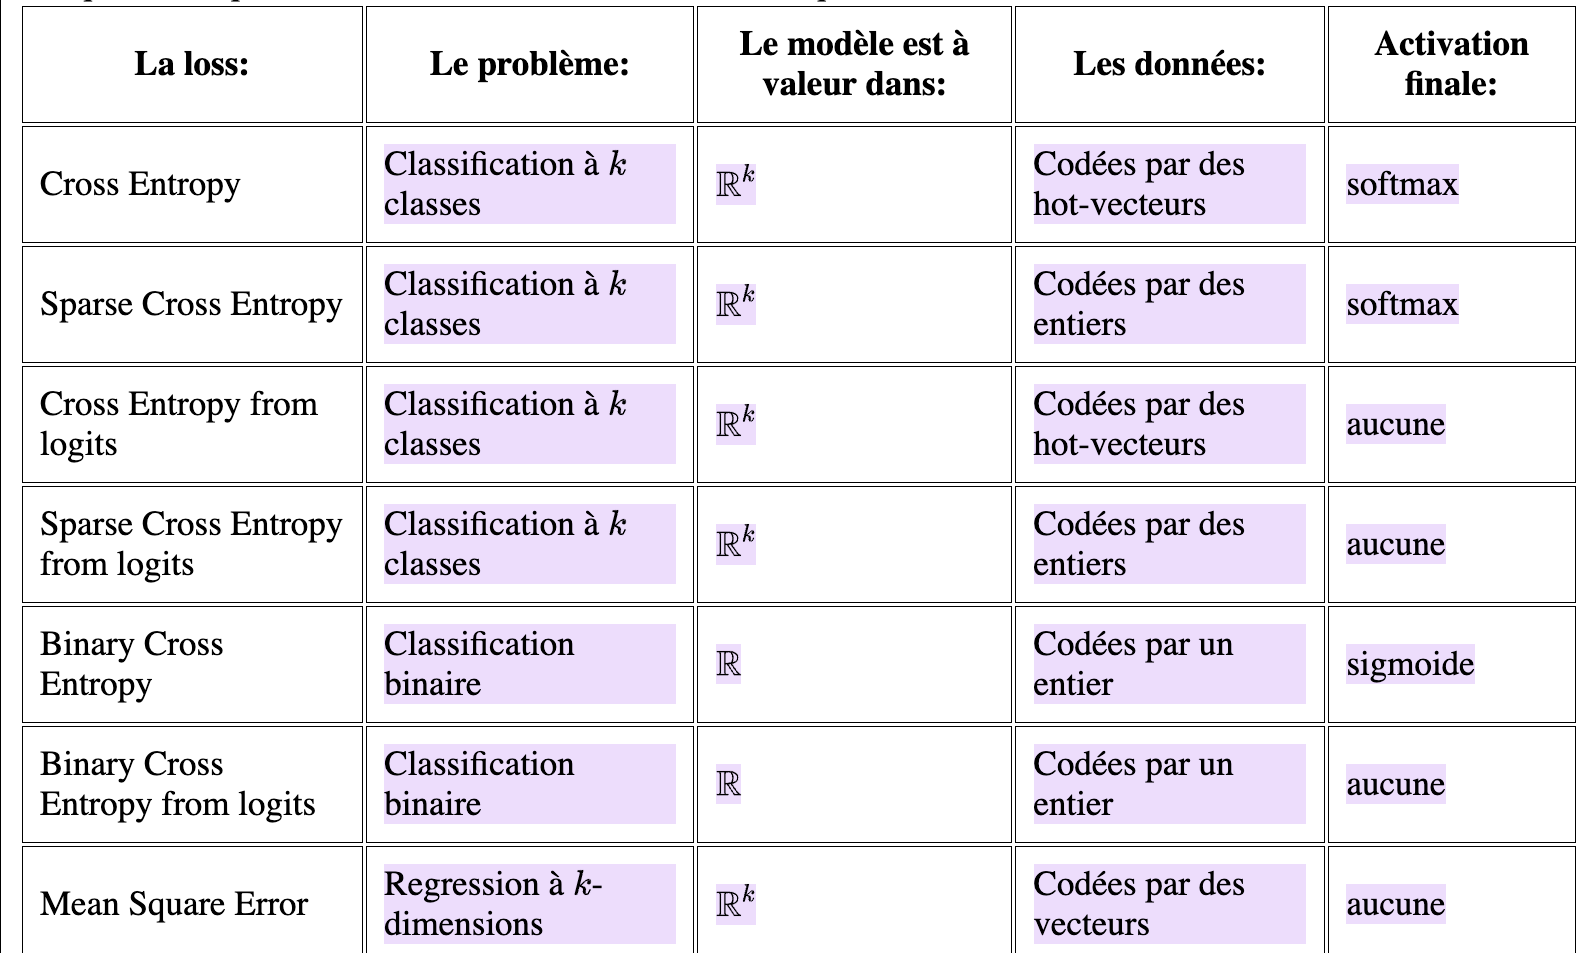